In [1]:
%%capture
#@title Install dependencies { display-mode: "form" }
!pip install numpy pandas matplotlib scipy scikit-learn
!pip install gensim spacy --upgrade

In [2]:
%%capture
#@title Clone our repository that contains the data { display-mode: "form" }
!git clone https://github.com/millawell/textexplorationen-in-der-digitalen-literaturwissenschaft
%cd textexplorationen-in-der-digitalen-literaturwissenschaft/code/

In [3]:
#@title import dependencies and load data { display-mode: "form" }
DEBUG = True #@param {type:"boolean"}
import json

from pathlib import Path
from functools import partial
from collections import Counter
from bisect import bisect_left

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from tqdm.notebook import tqdm
from spacy.lang.de import German
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import pairwise_distances

def iter_docs(in_path):
    with open(in_path, "r") as in_file:
        for iline, line in tqdm(enumerate(in_file), desc="load documents"):
            data = json.loads(line)
            yield data
            if iline > 10 and DEBUG:
                break
            
            
def iter_sents(docs):
    for doc in docs:
        text = doc['text']
        for isent, sent in tqdm(enumerate(nlp(text).sents), desc="load sentences"):
            sentence = []
            for token in sent:
                sentence.append(token.text)
            yield {
                'text': sentence,
                'sentence_id': isent,
                **{k:v for k,v in doc.items() if k!='text'}
            }
            if isent > 100 and DEBUG:
                break
                
def iter_chunks(docs, n_tokens=100):
    for doc in docs:
        tokenized = [t.text for t in nlp(doc['text'])]
        for i in range(0, len(tokenized), n_tokens):
            yield {
                'text': tokenized[i:i + n_tokens],
                **{k:v for k,v in doc.items() if k!='text'}
            }
            if i//n_tokens>100 and DEBUG:
                break

preprocessed_data_fn = Path("processed_data") / "eltec.jsonl"

nlp = German()
nlp.add_pipe("sentencizer")

for doc in iter_docs(preprocessed_data_fn):
    if len(doc['text']) >= nlp.max_length:
        nlp.max_length = len(doc['text'])+1

all_data = pd.DataFrame(list(iter_docs(preprocessed_data_fn)))
all_data

load documents: 0it [00:00, ?it/s]

load documents: 0it [00:00, ?it/s]

,text,author-name,book-title,subgenre,year,year-cat,canon-cat,gender-cat,length,length-cat,counter,Author-birth,Author-death,GND
0,Erster Theil Erstes Buch Erstes Kapitel. Der H...,"Willkomm, Ernst Adolf",Weisse Sclaven oder die Leiden des Volkes,foo,1845,T1,low,m,322371,long,1,1810,1886,http://d-nb.info/gnd/11739467X
1,"Ab der Landstraße. Ab der Landstraße, die durc...","Auerbach, Berthold",Der Lehnhold,foo,1854,T1,low,m,66067,medium,1,1812,1882,http://d-nb.info/gnd/11865103X
2,Prolog. Es war an einem Abende in der Mitte de...,"Ruppius, Otto",Der Pedlar,foo,1857,T1,low,m,89800,medium,1,1819,1864,http://d-nb.info/gnd/116708859
3,Erstes Capitel Gobelins Die kalten Strahlen ei...,"Otto, Louise",Nürnberg. Zweiter Band,foo,1858,T1,low,f,56702,medium,1,1819,1895,http://d-nb.info/gnd/118590901
4,"Erster Teil 1 »Nun, Meister Schwan, für diesma...","Kurz, Hermann",Der Sonnenwirt,foo,1854,T1,high,m,216063,long,1,1813,1873,http://d-nb.info/gnd/118778277
5,Georg Weerth Fragment eines Romans Seitwärts v...,"Weerth, Georg",Fragment eines Romans,foo,1846,T1,low,m,60551,medium,1,1822,1856,http://d-nb.info/gnd/117208612
6,1. Die Altertümer Mit dem an der Spitze dieses...,"Stifter, Adalbert",Die Mappe meines Urgroßvaters,foo,1841,T1,high,m,82220,medium,1,1805,1868,http://d-nb.info/gnd/118618156
7,"Der Lautenbacher. Die Glocke läutete hell, ihr...","Auerbach, Berthold",Der Lautenbacher,foo,1843,T1,low,m,31603,short,1,1812,1882,http://d-nb.info/gnd/11865103X
8,I. Ein prachtvoller Morgen lag über dem Missis...,"Ruppius, Otto",Das Vermächtnis des Pedlars,foo,1859,T1,low,m,97300,medium,1,1819,1864,http://d-nb.info/gnd/116708859
9,Erstes Kapitel »Das nenn' ich in der That ein ...,"Aston, Louise",Lydia,foo,1848,T1,low,f,61819,medium,1,1814,1871,http://d-nb.info/gnd/118650769


## One-Hot

In [4]:
#@title This cell outputs a one-hot encoding of the first sentence of the first document in the corpus. First, it iterates over the whole corpus to create a vocabulary. As you can see, the output is mostly zeros (*sparse*).{ display-mode: "form" }

vocab, counts = zip(
    *Counter(
        [token.text for doc in iter_docs(preprocessed_data_fn) for token in nlp(doc['text'])]
    ).most_common(10000)
)
vocab = sorted(vocab)

def get_index(query, vocab):
    'Locate the leftmost value exactly equal to x'
    i = bisect_left(vocab, query)
    if i != len(vocab) and vocab[i] == query:
        return i
    raise ValueError

def iter_embed_1hot(vocab, docs):
    for doc in docs:
        doc_i = []
        doc_j = []
        doc_data = []
        for itoken, token in enumerate(doc['text']):
            try:
                token_index = get_index(token, vocab)
                doc_i.append(itoken)
                doc_j.append(token_index)
                doc_data.append(1)
            except ValueError:
                pass
        yield coo_matrix((
            np.array(doc_data), 
            (
                np.array(doc_i, dtype=int),
                np.array(doc_j, dtype=int)
            )
        ), shape=(itoken+1, len(vocab)))

for embedding in iter_embed_1hot(vocab, iter_sents(iter_docs(preprocessed_data_fn))):
    break

embedding

load documents: 0it [00:00, ?it/s]

load documents: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

<7x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in COOrdinate format>

## Bag of Words

In [5]:
#@title This cell outputs a bag-of-words encoding of the first sentence of the first document in the corpus. Actually, it can be computed by summing over the first axis of the one-hot matrix from above.{ display-mode: "form" }

def iter_embed_bow(vocab, docs):
    for one_hot in iter_embed_1hot(vocab, docs):
        yield np.array(one_hot.sum(axis=0)).ravel()

for embedding in iter_embed_bow(vocab, iter_sents(iter_docs(preprocessed_data_fn))):
    break
embedding

load documents: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Word 2 Vec

In [6]:
#@title This cell trains word2vec embeddings on the whole corpus. It outputs the average embedding of the first sentence of the first document of the corpus.{ display-mode: "form" }

vector_size=20 #@param {type:"number"}
window=5 #@param {type:"number"}
min_count=2 #@param {type:"number"}
max_vocab_size=1000 #@param {type:"number"}
epochs=2 #@param {type:"number"}

class W2VDataset:
    def __init__(self, generator_factory):
        self.generator_factory = generator_factory
        self.length = None
 
    def __iter__(self):
        generator = self.generator_factory()
        i=0
        for i, it in enumerate(generator):
            yield it['text']
            
        self.length = i+1
            
    def __len__(self):
        if self.length is not None:
            return self.length
        
        self.length = len([_ for _ in self])
        return self.length
        

def train_w2v(vector_size=50, window=5, min_count=2, max_vocab_size=20000, epochs=2):

    w2vdataset = W2VDataset(
        partial(
            iter_sents, 
            iter_docs(preprocessed_data_fn)
        )
    )
    
    model = Word2Vec(
        sentences=w2vdataset,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        max_vocab_size=max_vocab_size,
        workers=4
    )
    
    model.train(
        w2vdataset,
        total_examples=len(w2vdataset),
        epochs=epochs
    )

    wv = model.wv

    vocab = wv.index_to_key
    vocab = sorted(vocab)

    vecs = [wv[it] for it in vocab]

    return pd.DataFrame(data=vecs, index=vocab)

def iter_embed_w2v(vecs, docs):
    for doc in docs:
        doc_representation = []
        for itoken, token in enumerate(doc['text']):
            try:
                doc_representation.append(vecs.loc[token])
            except KeyError:
                pass # some tokens are not embedded
        yield np.vstack(doc_representation).mean(axis=0)
            
w2vs = train_w2v(
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    max_vocab_size=max_vocab_size,
    epochs=epochs
)

for embedding in iter_embed_w2v(w2vs, iter_sents(iter_docs(preprocessed_data_fn))):
    break
embedding

load documents: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load documents: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

array([-0.04801775,  0.02503647, -0.04379793, -0.02195913, -0.0001755 ,
       -0.00148091, -0.0383062 ,  0.04807371,  0.02491028,  0.04616572,
       -0.04078959,  0.02247899, -0.02068539,  0.00412267,  0.04249309,
       -0.02231089,  0.0225875 , -0.03393481, -0.01774244,  0.04699254],
      dtype=float32)

## Authorship attribution

In [7]:
#@title This cell trains trains a classifier for authorship attribution. It outputs how well the method performs with the given parameters.{ display-mode: "form" }

n_tokens_per_sample=1000 #@param {type:"number"}
embedding_method="bow" #@param ['w2v', 'bow']

def train_simple_classifier(iterator, embedding_method, label_string):
    
    data = list(iterator)
    labels = [it[label_string] for it in data]
    features = np.vstack(list(embedding_method(data)))
    
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

    clf = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression(random_state=13198)),
    ])
    
    
    clf = clf.fit(train_features, train_labels)
    
    
    pred_labels = clf.predict(test_features)
    
    return f1_score(test_labels, pred_labels, average='macro')

iterator = iter_chunks(iter_docs(preprocessed_data_fn), n_tokens=n_tokens_per_sample)
embedding_method = partial(iter_embed_bow, vocab) if embedding_method == 'bow' else partial(iter_embed_w2v, w2vs)
score = train_simple_classifier(
  iter_chunks(iter_docs(preprocessed_data_fn)), 
  embedding_method,
  'author-name'
)
print(f"classifier reached f1 score of {score} on held-out data.")

load documents: 0it [00:00, ?it/s]

classifier reached f1 score of 0.8436198548955376 on held-out data.


## Visualize 3 dimensions with baricentric triangles

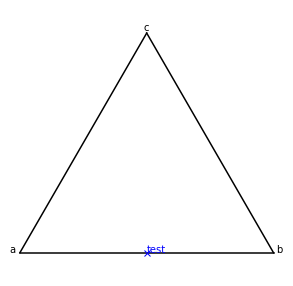

In [8]:
#@title with the baricentric triangle, 3-dimensional data ('weights') can be visualized ([Baryzentrische_Koordinaten auf Wikipedia](https://de.wikipedia.org/wiki/Baryzentrische_Koordinaten)). You can change the values and see where the point is plotted to get a feeling for it.
a_axis = .533 #@param {type:"number", min:0, max:1, step:0.1}
b_axis = .533 #@param {type:"number", min:0, max:1, step:0.1}
c_axis = 1e-5 #@param {type:"number", min:0, max:1, step:0.1}

def triangle(coordinates, labels, ax=None, axis_labels=["", "", ""], colors=None):
    
    if colors is None:
        colors = ['b' for _ in range(len(coordinates))]

    def get_cartesian_from_barycentric(b, t):
        return t.dot(b)
    
    
    triangle = np.transpose(np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]]))
    
    cartesian_coordinates = []
    
    for barycentric_coordinates in coordinates:
        if np.abs(barycentric_coordinates).sum() ==0:
            barycentric_coordinates = np.ones(3)
        barycentric_coordinates = barycentric_coordinates/barycentric_coordinates.sum()
        cartesian_coordinates.append(
            get_cartesian_from_barycentric(barycentric_coordinates, triangle)
        )
    
    
    if ax is None:
        _, ax = plt.subplots(figsize=(5,5))
    
    ax.plot(*triangle.T[:2].T, color="black")
    ax.plot(*triangle.T[1:].T, color="black")
    ax.plot(*triangle.T[[2,0]].T, color="black")
    

    for label, vec, color in zip(labels, cartesian_coordinates, colors):
        
        ax.annotate(label, vec, c=color)
        
        ax.plot(*vec.T, "x", c=color)
    
    offsets = [(-.04, 0), (.01,0), (-.012,.01)]
    for iaxis_label, axis_label in enumerate(axis_labels):
        plt.annotate(axis_label, triangle.T[iaxis_label]+np.array(offsets[iaxis_label]))

    plt.axis('off')
    plt.axis('equal')
    
    return ax

triangle(
    np.array([[a_axis,b_axis,c_axis]]),
    ['test'],
    axis_labels=["a", "b", "c"]
)
plt.show()

load documents: 0it [00:00, ?it/s]

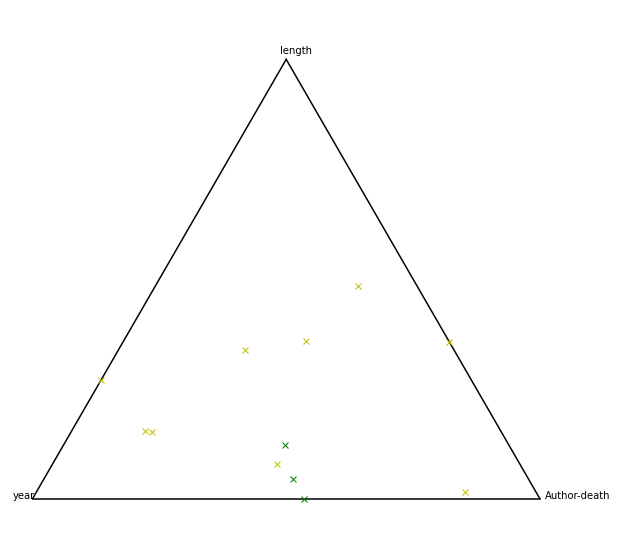

In [9]:
#@title This cell visualizes the corpus data as a baricentric triangle. { display-mode: "form" }
first_corner_category = "year" #@param ['Author-birth', 'Author-death', 'year', 'length']
second_corner_category = "Author-death" #@param ['Author-birth', 'Author-death', 'year', 'length']
third_corner_category = "length" #@param ['Author-birth', 'Author-death', 'year', 'length']
color_category = "gender" #@param ['gender', 'canon']

def get_label(rec):
    author = rec['author-name'][:15].replace(",", "").replace(" ", "-")
    title = rec['book-title'][:10].replace(",", "").replace(" ", "-")
    return f"{author}_{title}"

def get_color(rec):
    if color_category == 'gender':  
      return "y" if rec['gender-cat'] == 'm' else 'g'
    else:
      return "y" if rec['canon-cat'] == 'high' else 'g'

vals = np.array([
    (
        it[first_corner_category],
        it[second_corner_category],
        it[third_corner_category],
        get_label(it),
        get_color(it)
    )
    for it in iter_docs(preprocessed_data_fn)
])

vals, labels, colors = vals[:,:-2].astype(int), vals[:,-2], vals[:,-1]

fig, ax = plt.subplots(figsize=(10,10))

vals = vals-vals.min(axis=0)
vals = vals/vals.max(axis=0)

_ = triangle(
    vals,
    ['' for it in labels],
    axis_labels=[
                 first_corner_category,
                 second_corner_category,
                 third_corner_category
    ],
    ax=ax,
    colors=colors
)

## Analogy tests

(using word lists from https://github.com/devmount/GermanWordEmbeddings#evaluation)

In [10]:
%%capture
#@title Load and preprocess German analogy test data.  { display-mode: "form" }

!git clone https://github.com/devmount/GermanWordEmbeddings.git

def queries_from_lists(list_):
    queries, answers = [], []
    
    for row in list_:
        
        for qw in row:
            queries.append(qw)
            answers.append([])
            for aw in row:
                if aw != qw:
                    answers[-1].append(aw)
                    
    return queries, answers


def load_syntactic_analogies():
    base_path = Path("GermanWordEmbeddings/src")
    
    adjectives = base_path / "adjectives.txt"
    adjectives = [it.split("-")  for it in open(adjectives).read().split("\n")]
    
    nouns = base_path / "nouns.txt"
    nouns = [it.split("-")  for it in open(nouns).read().split("\n")]
    
    verbs = base_path / "verbs.txt"
    verbs = [it.split("-")  for it in open(verbs).read().split("\n")]
    
    return queries_from_lists(adjectives + nouns + verbs)
    

def load_semantic_analogies():
    base_path = Path("GermanWordEmbeddings/src")
    
    bestmatch = base_path / "bestmatch.txt"
    bestmatch = [it.split("-") for it in open(bestmatch).read().split("\n") if ":" not in it]
    
    opposite = base_path / "opposite.txt"
    opposite = [it.split("-")  for it in open(opposite).read().split("\n")]
    
    return queries_from_lists(bestmatch + opposite)


def evaluate(embeddings, queries, answers, n_candidates=20):
    
    pw_distances = pairwise_distances(embeddings.values, metric='cosine')
    pw_distances = pd.DataFrame(
        data=pw_distances,
        columns=embeddings.index,
        index=embeddings.index
    )
    
    num_found_queries = 0
    num_total_queries = len(queries)
    num_found_answers = 0
    num_findable_answers = 0
    num_total_answers = sum(map(len, answers))
    
    for query, answers in zip(queries, answers):
        try:
            found_row = pw_distances.loc[query]
            
            candidates = set(
                found_row.sort_values()[:n_candidates].index.tolist()
            )
            answers = set(answers)

            num_found_queries += 1
            num_findable_answers += len(answers)
            num_found_answers += len(candidates & answers)
    
        except KeyError:
            pass
        
    return {
        "found_queries": num_found_queries/num_total_queries,
        "found_answers": num_found_answers/num_findable_answers
    }
syntactic_queries, syntactic_answers = load_syntactic_analogies()
semantic_queries, semantic_answers = load_semantic_analogies()

In [11]:
#@title Evaluate w2v embeddings on syntactic and semantic analogies. { display-mode: "form" }
vector_size=20 #@param {type:"number"}
window=5 #@param {type:"number"}
min_count=2 #@param {type:"number"}
max_vocab_size=1000 #@param {type:"number"}
epochs=2 #@param {type:"number"}

embeddings = train_w2v(
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    max_vocab_size=max_vocab_size,
    epochs=epochs
)
print("syntactic")
print(evaluate(embeddings, syntactic_queries, syntactic_answers))

print("semantic")
print(evaluate(embeddings, semantic_queries, semantic_answers))

load documents: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

load sentences: 0it [00:00, ?it/s]

syntactic
{'found_queries': 0.048, 'found_answers': 0.0}
semantic
{'found_queries': 0.07009345794392523, 'found_answers': 0.0}
